## Compare K-kAN with different grid points ability in function interpolation with MLP

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from KKANLayer import KKANLayer

In [172]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])
    # add noise
    noise = np.random.normal(0, 0.2, y.shape)
    y += noise
    return y

In [173]:
# Define MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input

In [174]:
# Define KKANs
# g = 60
g = 100
class KKAN(nn.Module):
    def __init__(self):
        super(KKAN, self).__init__()
        self.KKAN1 = KKANLayer(1, 8, g)
        self.KKAN2 = KKANLayer(8, 1, g)

    def forward(self, x):
        x = self.KKAN1(x)
        x = self.KKAN2(x)
        return x

# Define KKANs
g = 30
class KKAN30(nn.Module):
    def __init__(self):
        super(KKAN30, self).__init__()
        self.KKAN1 = KKANLayer(1, 8, g)
        self.KKAN2 = KKANLayer(8, 1, g)

    def forward(self, x):
        x = self.KKAN1(x)
        x = self.KKAN2(x)
        return x

# Define KKANs
g = 5
class KKAN5(nn.Module):
    def __init__(self):
        super(KKAN5, self).__init__()
        self.KKAN1 = KKANLayer(1, 8, g)
        self.KKAN2 = KKANLayer(8, 1, g)

    def forward(self, x):
        x = self.KKAN1(x)
        x = self.KKAN2(x)
        return x

In [175]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

/tmp/ipython-input-172-3883575799.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
/tmp/ipython-input-172-3883575799.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
/tmp/ipython-input-172-3883575799.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])


In [176]:
# Instantiate models
mlp_model = SimpleMLP()
kkan_model = KKAN()
kkan30_model = KKAN30()
kkan5_model = KKAN5()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)
optimizer_kkan = torch.optim.Adam(kkan_model.parameters(), lr=0.03)
optimizer_kkan30 = torch.optim.Adam(kkan30_model.parameters(), lr=0.03)
optimizer_kkan5 = torch.optim.Adam(kkan5_model.parameters(), lr=0.03)

mlp_losses = []
kkan_losses = []
kkan30_losses = []
kkan5_losses = []

# Train the models
epochs = 1500
for epoch in range(epochs):
    # MLP
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()
    # KKAN
    optimizer_kkan.zero_grad()
    outputs_kkan = kkan_model(x_train)
    loss_kkan = criterion(outputs_kkan, y_train)
    loss_kkan.backward()
    optimizer_kkan.step()

    # KKAN30
    optimizer_kkan30.zero_grad()
    outputs_kkan30 = kkan30_model(x_train)
    loss_kkan30 = criterion(outputs_kkan30, y_train)
    loss_kkan30.backward()
    optimizer_kkan30.step()

    # KKAN5
    optimizer_kkan5.zero_grad()
    outputs_kkan5 = kkan5_model(x_train)
    loss_kkan5 = criterion(outputs_kkan5, y_train)
    loss_kkan5.backward()
    optimizer_kkan5.step()

    if epoch % 10 == 0:
        mlp_losses.append(loss_mlp.item())
        kkan_losses.append(loss_kkan.item())
        kkan30_losses.append(loss_kkan30.item())
        kkan5_losses.append(loss_kkan5.item())
        print(f'Epoch {epoch + 1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, K-KAN Loss: {loss_kkan.item():.4f}, K-KAN30 Loss: {loss_kkan30.item():.4f}, K-KAN5 Loss: {loss_kkan5.item():.4f}')

Epoch 1/1500, MLP Loss: 0.5194, K-KAN Loss: 2.7679, K-KAN30 Loss: 2.0978, K-KAN5 Loss: 0.5241
Epoch 11/1500, MLP Loss: 0.4310, K-KAN Loss: 0.5769, K-KAN30 Loss: 0.6118, K-KAN5 Loss: 0.5463
Epoch 21/1500, MLP Loss: 0.4173, K-KAN Loss: 0.5221, K-KAN30 Loss: 0.5613, K-KAN5 Loss: 0.5029
Epoch 31/1500, MLP Loss: 0.3340, K-KAN Loss: 0.4830, K-KAN30 Loss: 0.5392, K-KAN5 Loss: 0.4395
Epoch 41/1500, MLP Loss: 0.2795, K-KAN Loss: 0.4650, K-KAN30 Loss: 0.5287, K-KAN5 Loss: 0.3129
Epoch 51/1500, MLP Loss: 0.2496, K-KAN Loss: 0.4419, K-KAN30 Loss: 0.5237, K-KAN5 Loss: 0.2346
Epoch 61/1500, MLP Loss: 0.2423, K-KAN Loss: 0.3962, K-KAN30 Loss: 0.5211, K-KAN5 Loss: 0.2300
Epoch 71/1500, MLP Loss: 0.2385, K-KAN Loss: 0.3273, K-KAN30 Loss: 0.5189, K-KAN5 Loss: 0.2274
Epoch 81/1500, MLP Loss: 0.2369, K-KAN Loss: 0.2687, K-KAN30 Loss: 0.5161, K-KAN5 Loss: 0.2257
Epoch 91/1500, MLP Loss: 0.2363, K-KAN Loss: 0.2324, K-KAN30 Loss: 0.5121, K-KAN5 Loss: 0.2247
Epoch 101/1500, MLP Loss: 0.2360, K-KAN Loss: 0.228

In [177]:
# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
x_test_dkn = x_test.reshape([1, 400, 1]).unsqueeze(1)

y_pred_mlp = mlp_model(x_test).detach()
y_pred_kkan = kkan_model(x_test).detach()
y_pred_kkan30 = kkan30_model(x_test).detach()
y_pred_kkan5 = kkan5_model(x_test).detach()

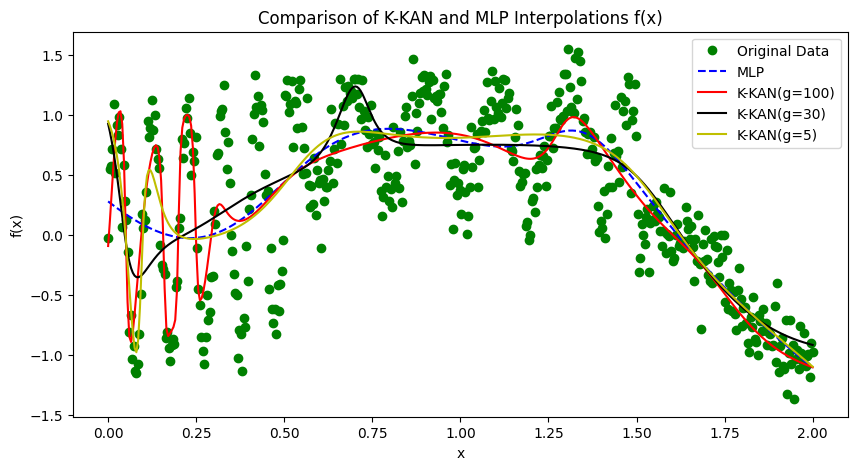

In [178]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'go', label='Original Data')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'b--', label='MLP')
plt.plot(x_test.numpy(), y_pred_kkan.numpy(), 'r', label='K-KAN(g=100)')
plt.plot(x_test.numpy(), y_pred_kkan30.numpy(), 'k', label='K-KAN(g=30)')
plt.plot(x_test.numpy(), y_pred_kkan5.numpy(), 'y', label='K-KAN(g=5)')
plt.title('Comparison of K-KAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

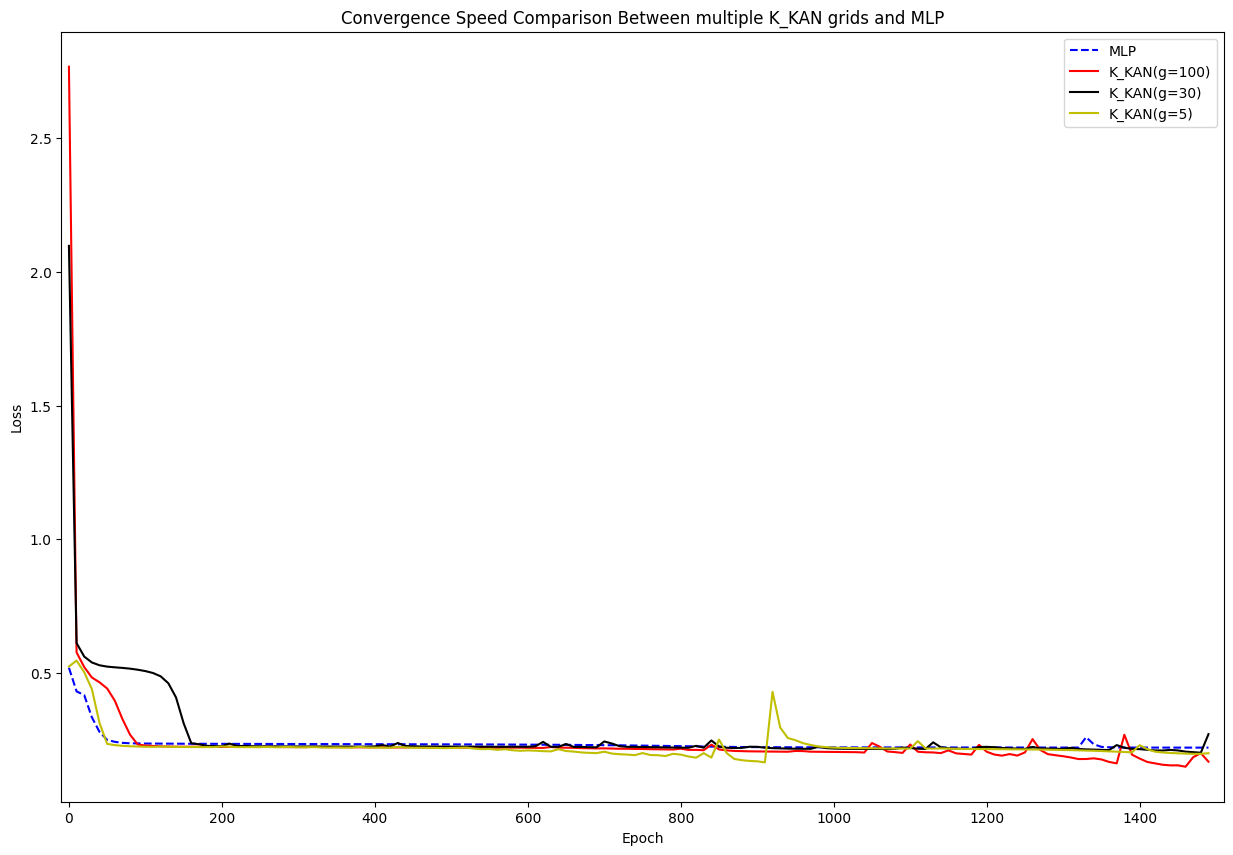

In [179]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(15, 10))
plt.plot(range(0, epochs, 10), mlp_losses, 'b--', label='MLP')
plt.plot(range(0, epochs, 10), kkan_losses, 'r', label='K_KAN(g=100)')
plt.plot(range(0, epochs, 10), kkan30_losses, 'k', label='K_KAN(g=30)')
plt.plot(range(0, epochs, 10), kkan5_losses, 'y', label='K_KAN(g=5)')
plt.title('Convergence Speed Comparison Between multiple K_KAN grids and MLP')
plt.xlim(-10, 1510)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()